# Predicting Single Unit Property Values Using Linerar Regression
## By Justin Sullivan
## March 23, 2021

---

In [1]:
#Import required modules ==> See data dictionary for module descriptions

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from env import host, user, password
import evaluate
import prepare
import acquire
import explore
import preprocess
import os
from math import sqrt
import math

from scipy import stats

import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.formula.api import ols

from tabulate import tabulate

# Handle large numbers w/o using scientific notation
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings('ignore')

## Project Planning

### Initial Questions
- What constitutes a single unit property?
<br>
- What features are the best drivers for predicting a single unit property's value?

### Initial Hypotheses

H<sub>o</sub>: The features bedroom counts, bathroom counts, and finished square feet offer no predictive value for a single unit property's value.<br>
H<sub>a</sub>: These features help predict a single unit property's value. 

---

## Data Acquisition

> Zillow data is acquired from the CodeUp MySQL database. The full SQL query is included in my acquire.py module. The query filters for Zillow single unit properties that were sold between May 1, 2017 and August 31, 2017.

In [2]:
#Acquire the data 
df = acquire.get_zillow_data(cached=False)
df.head(2)

,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,latitude,longitude,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,propertylandusetypeid,propertylandusedesc
0,11721753,2.000,3.000,2.000,1316.000,6037.000,34033180.000,-118355396.000,41948.000,205123.000,163175.000,2627.480,261.000,Single Family Residential
1,11289917,2.000,3.000,2.000,1458.000,6037.000,34686163.000,-118113100.000,108890.000,136104.000,27214.000,2319.900,261.000,Single Family Residential


In [3]:
#Preview the shape of the acquired dataframe
table = [['Dataframe Name', '# of rows', '# of cols'], ['df', df.shape[0], df.shape[1]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════╤═════════════╤═════════════╕
│ Dataframe Name   │   # of rows │   # of cols │
╞══════════════════╪═════════════╪═════════════╡
│ df               │       29271 │          14 │
╘══════════════════╧═════════════╧═════════════╛


In [4]:
#Preview a list of columns
df.columns.to_list()

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'fips',
 'latitude',
 'longitude',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'propertylandusetypeid',
 'propertylandusedesc']

In [5]:
#Pull the info stats for the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29271 entries, 0 to 29270
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      29271 non-null  int64  
 1   bathroomcnt                   29271 non-null  float64
 2   bedroomcnt                    29271 non-null  float64
 3   calculatedbathnbr             29158 non-null  float64
 4   calculatedfinishedsquarefeet  29197 non-null  float64
 5   fips                          29271 non-null  float64
 6   latitude                      29271 non-null  float64
 7   longitude                     29271 non-null  float64
 8   structuretaxvaluedollarcnt    29223 non-null  float64
 9   taxvaluedollarcnt             29270 non-null  float64
 10  landtaxvaluedollarcnt         29270 non-null  float64
 11  taxamount                     29270 non-null  float64
 12  propertylandusetypeid         29271 non-null  float64
 13  p

---

## Data Preparation

**Key Data Cleaning Steps**<br> 
    - Correctly format latitude and longitude<br>
    - Drop rows containing missing values<br>
    - Validate Data

In [6]:
#Use prepare.py module to clean the data
df = prepare.clean_zillow(df)
df.head(2)

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,latitude,longitude,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,propertylandusetypeid,propertylandusedesc,county,tax_rate,bath_per_sqft
parcelid,,,,,,,,,,,,,,,,
11721753,2.000,3.000,2.000,1316.000,6037,34.033,-118.355,41948.000,205123.000,163175.000,2627.480,261.000,Single Family Residential,Los Angeles,0.013,0.002
11289917,2.000,3.000,2.000,1458.000,6037,34.686,-118.113,108890.000,136104.000,27214.000,2319.900,261.000,Single Family Residential,Los Angeles,0.017,0.001


In [7]:
#Preview the shape of the cleaned dataframe
table = [['Dataframe Name', '# of rows', '# of cols'], ['df', df.shape[0], df.shape[1]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════╤═════════════╤═════════════╕
│ Dataframe Name   │   # of rows │   # of cols │
╞══════════════════╪═════════════╪═════════════╡
│ df               │       29195 │          16 │
╘══════════════════╧═════════════╧═════════════╛


 **Key Data Preparation Steps**<br>
    - Use fips to caluclate county location name for each property<br>
    - Calculate tax_rate: taxamount / taxvaluedollarcnt<br>
    - Evaluate outliers and decide how to handle

In [8]:
#Evaluate Outliers for taxvaluedollarcnt
q1, q3 = df.taxvaluedollarcnt.quantile([.25, .75])
    
iqr = q3 - q1
    
# Create variables holding upper and lower cutoff values using common formula. Tweak as you like.
    
tax_upperbound = q3 + 3 * iqr
    
tax_lowerbound = q1 - 3 * iqr 
#==> The lowerbound is negative and since there are no negative values, there are no lowerbound outliers

print(f'The upperbound cutoff for outlier in the target of taxvaluedollarcnt is {tax_upperbound}')
print(f'The lowerbound cutoff for outlier in the target of taxvaluedollarcnt is {tax_lowerbound}')

#Determine how many observations will be lost by dropping outliers
print(f'The number of taxvaluedollarcnt outliers is: {len(df[df.taxvaluedollarcnt > tax_upperbound])} or {len(df[df.taxvaluedollarcnt > tax_upperbound])/len(df):.2%}')

The upperbound cutoff for outlier in the target of taxvaluedollarcnt is 1917044.5
The lowerbound cutoff for outlier in the target of taxvaluedollarcnt is -1083726.0
The number of taxvaluedollarcnt outliers is: 815 or 2.79%


<AxesSubplot:>

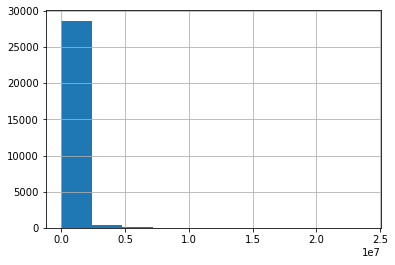

In [9]:
#Visualize the dist of property values before addressing outliers
df.taxvaluedollarcnt.hist()

<AxesSubplot:xlabel='taxvaluedollarcnt'>

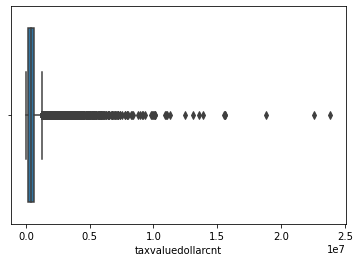

In [10]:
#Box and whisker for tax value dollar count...Visualize potential outliers
sns.boxplot(df.taxvaluedollarcnt)

In [11]:
#Use prepare_zillow_2nd function from prepare.py module to prepare the data for analysis
df = prepare.prepare_zillow_2nd(df)

#Preview the shape of the prepared dataframe
table = [['Dataframe Name', '# of rows', '# of cols'], ['df', df.shape[0], df.shape[1]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════╤═════════════╤═════════════╕
│ Dataframe Name   │   # of rows │   # of cols │
╞══════════════════╪═════════════╪═════════════╡
│ df               │       28380 │          10 │
╘══════════════════╧═════════════╧═════════════╛


### Preparation Decisions & Impact
**Drop observations containing missing null values**<br>
    - Loss of 76 observations which is 0.0025% of the original dataframe<br>  
**Drop outliers based on property value, where the value is > $1,908,653**<br>
    - Loss of 264 additional observations which is 0.09% of the orginal dataframe<br>      

In [12]:
.0025+.09

0.0925

---

## Data Exploration & Preprocessing

> This stage of the data science pipeline focuses on the following tasks:<br><br>
    - <u>First</u>: Splitting the dataframe in train, validate, and test for univariate exploration on the train data set.<br>
    <br>
    - <u>Second</u>: Conduct bivariate and multivariate exploration to examine how the different features interact with each other and the target variable, taxvaluedollarcnt<br><br>
    - <u>Third</u>: Formulate hypotheses about what features are driving the target. Use statistical testing for analysis of these questions/ideas.<br><br>
    - <u>Fourth</u>: Ecode any categorical features. Further split the data and separate the target into y-train and the features into X-Train. Scale the numeric data as ncessary.<br><br>
    - <u>Fifth</u>: Utilize scikit learn's feature seletion tools to assist with choosing the best features to carry over into modeling. 

In [13]:
#Split Data into train, validate, and test for exploration
train, validate, test = prepare.split_stratify_continuous(df, 'taxvaluedollarcnt', bins=5)

#Confirm the split was successful
table = [['Dataframe Name', '# of rows', '# of cols'], ['train', train.shape[0], train.shape[1]],
                                                        ['validate', validate.shape[0], validate.shape[1]], 
                                                         ['test', test.shape[0], test.shape[1]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════╤═════════════╤═════════════╕
│ Dataframe Name   │   # of rows │   # of cols │
╞══════════════════╪═════════════╪═════════════╡
│ train            │       15892 │          10 │
├──────────────────┼─────────────┼─────────────┤
│ validate         │        5676 │          10 │
├──────────────────┼─────────────┼─────────────┤
│ test             │        6812 │          10 │
╘══════════════════╧═════════════╧═════════════╛


### Univariate Exploration

In [14]:
#Breakout Categorical and Quantitative Features for Univariate Exploratory Visualization
cat_vars =['propertylandusedesc', 'county']
quant_vars = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude',
             'taxvaluedollarcnt', 'tax_rate', 'bath_per_sqft']

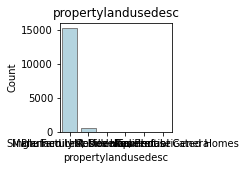

                                                                   propertylandusedesc  \
Single Family Residential                                    Single Family Residential   
Planned Unit Development                                      Planned Unit Development   
Manufactured, Modular, Prefabricated Homes                                 Mobile Home   
Mobile Home                                 Manufactured, Modular, Prefabricated Homes   
Residential General                                                          Townhouse   
Townhouse                                                          Residential General   

                                            Count  Percent  
Single Family Residential                   15302   96.290  
Planned Unit Development                      544    3.420  
Manufactured, Modular, Prefabricated Homes     21    0.130  
Mobile Home                                    19    0.120  
Residential General                             4    0.030  
Tow

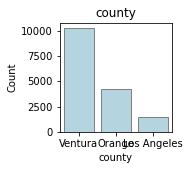

                  county  Count  Percent
Los Angeles      Ventura  10243   64.450
Orange            Orange   4231   26.620
Ventura      Los Angeles   1418    8.920
_________________________________________________________________


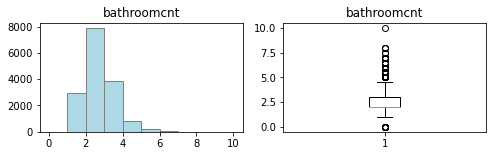

count   15892.000
mean        2.288
std         0.922
min         0.000
25%         2.000
50%         2.000
75%         3.000
max        10.000
Name: bathroomcnt, dtype: float64


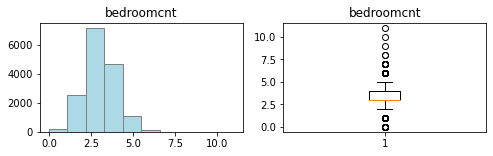

count   15892.000
mean        3.290
std         0.911
min         0.000
25%         3.000
50%         3.000
75%         4.000
max        11.000
Name: bedroomcnt, dtype: float64


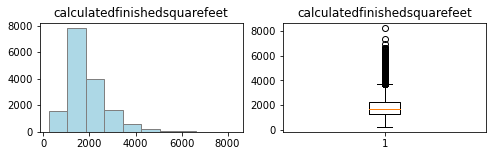

count   15892.000
mean     1872.663
std       833.071
min       240.000
25%      1284.000
50%      1668.000
75%      2264.000
max      8251.000
Name: calculatedfinishedsquarefeet, dtype: float64


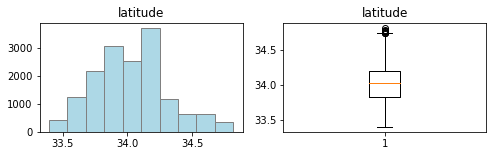

count   15892.000
mean       34.028
std         0.274
min        33.394
25%        33.828
50%        34.032
75%        34.193
max        34.819
Name: latitude, dtype: float64


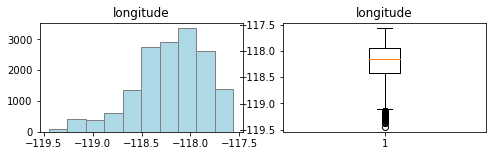

count   15892.000
mean     -118.203
std         0.364
min      -119.448
25%      -118.417
50%      -118.157
75%      -117.933
max      -117.559
Name: longitude, dtype: float64


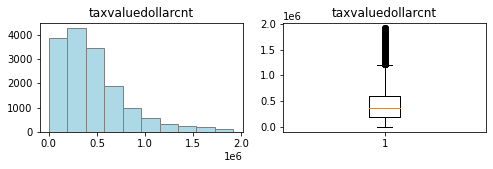

count     15892.000
mean     452523.387
std      351025.907
min        1000.000
25%      197025.500
50%      374372.000
75%      601976.250
max     1916314.000
Name: taxvaluedollarcnt, dtype: float64


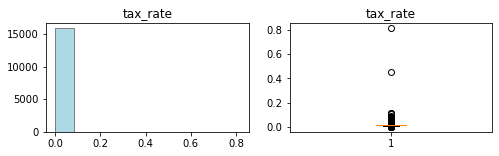

count   15892.000
mean        0.013
std         0.008
min         0.000
25%         0.012
50%         0.012
75%         0.014
max         0.816
Name: tax_rate, dtype: float64


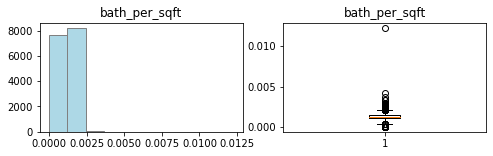

count   15892.000
mean        0.001
std         0.000
min         0.000
25%         0.001
50%         0.001
75%         0.001
max         0.012
Name: bath_per_sqft, dtype: float64


In [15]:
#Call explore univariate from explore module to visualize the distributions of the features.
explore.explore_univariate(train, cat_vars, quant_vars)

### Univariate Exploration Takeaways:
    - 95% of the properties are Single Family Residential
    - Need to remove Cluster Home from SQL Query
    - 65% of the properties are in Los Angeles County
    - Bathroom count is fairly evenly distributed...slightly right tailed
    - Bedroom count is normally distributed
    - Finished Square Feet is also fairly evenly distributed, but still right skewed
    - Taxvaluedollarcnt is right skewed

### Bivariate & Multivariate Exploration

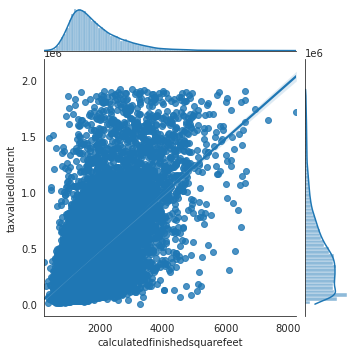

In [16]:
with sns.axes_style('white'):
    j = sns.jointplot("calculatedfinishedsquarefeet", "taxvaluedollarcnt", data=train, kind='reg', height=5);
plt.show()

### Multivariate Exploration or How do features interact with each other and the target?

(0.0, 10.0)

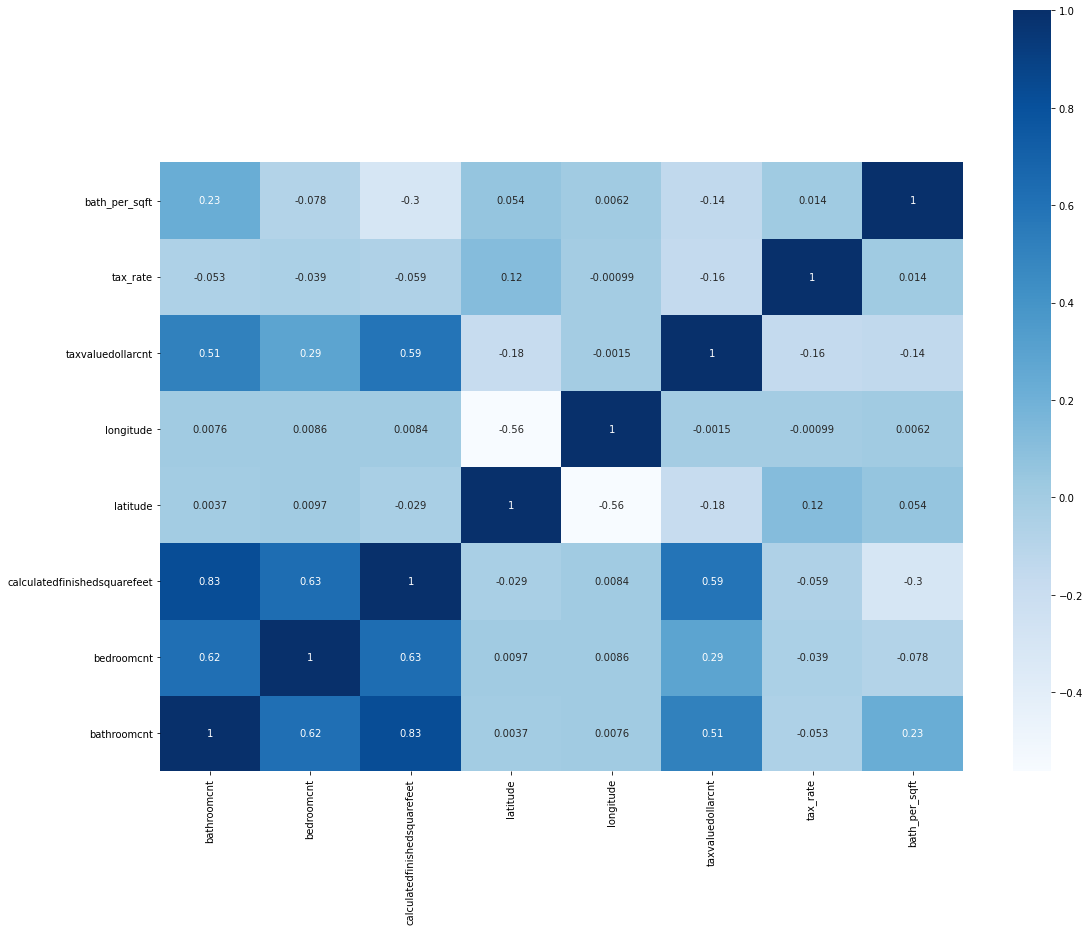

In [17]:
plt.figure(figsize=(18,14))
sns.heatmap(train.corr(), cmap='Blues', annot=True)
plt.ylim(0, 10)

### Hypothesize and Run Statistical Testing

**Takeaways after some visualizations:**
- Expected upward trend in relationship between # of bedrooms and # of bathrooms
- Bedrooms and Bathrooms appear to correlate 
- Seems to be an outlier pulling down the slope of the regression line when comparing calculatedfinishedsquarefeet and taxvaluedollarcnt
- Squarefeet and bathrooms seems more closely related than squarefeet and bedrooms
    - This seems to make sense from my own experience. Some "bedrooms" can be very small. Bathrooms are more difficult to cut out squarefeet on. 


**Statistical Testing to run:**
- Is there a correlation between squarefeet and tax value
- Bedrooms and Bathrooms seem to be tightly correlated. Test this.
    - Test to see if one is a better feature of value than the other. Do I need both?

#### Correlation Test for Square Feet and Tax Value

H<sub>o</sub> = There is no linear correlation between a single unit property's value and the number of finished square feet. 

H<sub>*a*</sub> = There is a correlation between a property's value and square feet.

In [18]:
#Set confidence interval and alpha for Pearson's Correlation Test
confidence_int = .95
a = 1 - confidence_int

#Set the correlation test
corr, p = stats.pearsonr(train.calculatedfinishedsquarefeet, train.taxvaluedollarcnt)
print(f"Pearson's correlation coefficient is: {corr} and the p-value is: {p}")

#Analyze the results
if p < a:
    print("Reject the null hypothesis.")
    print("Move forward with the understanding that there is a correlation between square feet and  tax value.")
else:
    print("Fail to reject the null hypothesis. Proceed with an understanding that there is no linear correlation.")

Pearson's correlation coefficient is: 0.5889972067057132 and the p-value is: 0.0
Reject the null hypothesis.
Move forward with the understanding that there is a correlation between square feet and  tax value.


> **Takeaway:**
    - There is a correlation of .58, finishedsquarefeet will be a feature that I utililze going forward with into modeling. 

#### Correlation Test for Bedrooms and Value

H<sub>o</sub> = There is no linear correlation between the number of bedrooms for a single unit property and the property's value. 

H<sub>*a*</sub> = There is a correlation between the number of bedrooms and a property's value.

In [19]:
#Set confidence interval and alpha for Pearson's Correlation Test
confidence_int = .95
a = 1 - confidence_int

#Setup the test
corr, p = stats.pearsonr(train.bedroomcnt, train.taxvaluedollarcnt)
print(f"Pearson's correlation coefficient is: {corr} and the p-value is: {p}")

if p < a:
    print("Reject the null hypothesis.")
    print("Move forward with the understanding that there is a correlation between bedroom count and property value.")
else:
    print("Fail to reject the null hypothesis. Proceed with an understanding that there is no linear correlation.")

Pearson's correlation coefficient is: 0.29076851330356945 and the p-value is: 3.455374025867577e-307
Reject the null hypothesis.
Move forward with the understanding that there is a correlation between bedroom count and property value.


> **Takeaways:**<br>
    - Weaker correlation coefficient for bedroom count and property value than the correlation for square feet and property value. <br>
    - Still, bedroom count is a feature that I will proceed with as a driver for property value going into modeling.

#### Correlation Test for Bathrooms and Value

H<sub>o</sub> = There is no linear correlation between the number of bathrooms for a single unit property and the property's value. 

H<sub>*a*</sub> = There is a correlation between the number of bathrooms and a property's value.

In [20]:
#Set confidence interval and alpha for Pearson's Correlation Test
confidence_int = .95
a = 1 - confidence_int

corr, p = stats.pearsonr(train.bathroomcnt, train.taxvaluedollarcnt)
print(f"Pearson's correlation coefficient is: {corr} and the p-value is: {p}")

if p < a:
    print("Reject the null hypothesis.")
    print("Move forward with the understanding that there is a correlation between bathroom count and property value.")
else:
    print("Fail to reject the null hypothesis. Proceed with an understanding that there is no linear correlation.")


Pearson's correlation coefficient is: 0.5131458384670612 and the p-value is: 0.0
Reject the null hypothesis.
Move forward with the understanding that there is a correlation between bathroom count and property value.


> **Takeaways:**<br>
    - The number of bathrooms is more correlated with a property's value than bedrooms.<br>
        - This is aligned with one of my initial hypotheses...<br>
            - Could be due to the fact that there is greater variance in bedroom square footage than bathroom square footage? If I had that data, that might be interesting to look at...<br>
    - Proceed with bathrooms as a feature for predicting a property's tax value

### Encode, Scale, and Split the Data

In [21]:
df.drop(columns={'tax_rate'}, inplace=True)

#Create dummies
object_cols = preprocess.get_object_cols(df)
df = preprocess.create_dummies(df, object_cols)

#Split the data into X_train, y_train...
X_train, y_train, X_validate, y_validate, X_test, y_test = preprocess.train_validate_test(df, 'taxvaluedollarcnt', bins=5)

#Scale the data
numeric_cols = preprocess.get_numeric_X_cols(X_train, object_cols)
X_train_scaled, X_validate_scaled, X_test_scaled = preprocess.min_max_scale(X_train, X_validate, X_test, numeric_cols)

### Feature Selection and Engineering

In [22]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 4 features
f_selector = SelectKBest(f_regression, k=4)

# find the top 4 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
print(f'SelectKBest preferences the following as the top 4 features for predicting taxvaluedollarcnt: {f_feature}')

SelectKBest preferences the following as the top 4 features for predicting taxvaluedollarcnt: ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude']


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 4)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
rfe_feature

['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'bath_per_sqft']

> **Takeaways:**<br>
    - As bathroomcnt, bedroomcnt, and calculatedfinishedsquarefeet are the top three reccomended features from Sklearn's feature selection modules, I will control for only these three features during modeling.<br>
    - I did add in additional features for other model developments during the process of building a predictive model, but none of the models did as well as these three models with these three features on the in-sample data. 

## Modeling and Evaluation

### Baseline Model

In [24]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
X_test = pd.DataFrame(X_test)

# 1. Predict taxvaluedollarcnt_pred_mean
taxvaluedollarcnt_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['taxvaluedollarcnt_pred_mean'] = taxvaluedollarcnt_pred_mean
y_validate['taxvaluedollarcnt_pred_mean'] = taxvaluedollarcnt_pred_mean
y_test['taxvaluedollarcnt_pred_mean'] = taxvaluedollarcnt_pred_mean

# 2. compute taxvaluedollarcnt_pred_median
taxvaluedollarcnt_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['taxvaluedollarcnt_pred_median'] = taxvaluedollarcnt_pred_median
y_validate['taxvaluedollarcnt_pred_median'] = taxvaluedollarcnt_pred_median
y_test['taxvaluedollarcnt_pred_median'] = taxvaluedollarcnt_pred_median

In [25]:
#Evaluate the baseline model using the mean
evaluate.baseline_mean_errors(y_train.taxvaluedollarcnt)

{'sse': 1958076108326954.2,
 'mse': 123211433949.5944,
 'rmse': 351014.86286138144}

In [26]:
#Evaluate the baseline model using the median
evaluate.baseline_median_errors(y_train.taxvaluedollarcnt)

{'sse': 2055138712048429.0,
 'mse': 129319073247.44708,
 'rmse': 359609.61228455376}

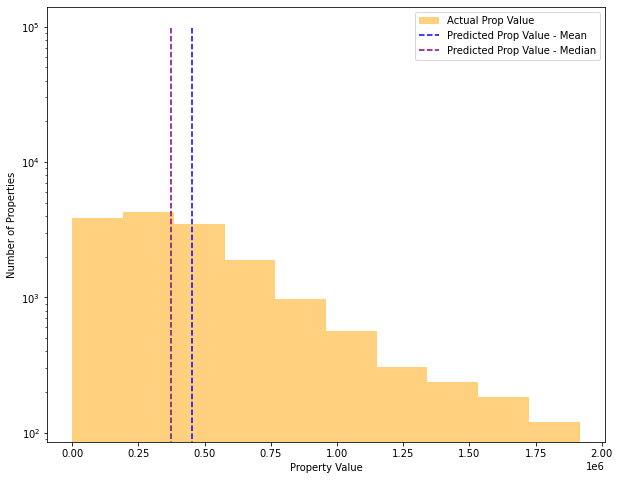

In [27]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(10, 8))
plt.hist(y_train.taxvaluedollarcnt, color='orange', alpha=.5, label="Actual Prop Value", log=True)
plt.vlines(y_train.taxvaluedollarcnt.mean(), 0, 10**5,  ls='--', color='blue', label="Predicted Prop Value - Mean")
plt.vlines(y_train.taxvaluedollarcnt.median(), 0, 10**5,  ls='--', color='purple', label="Predicted Prop Value - Median")
plt.xlabel("Property Value")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

In [28]:
#Now that I have established the mean as the baseline, I will drop the median and rename baseline to yhat_baseline
y_train.drop(columns={'taxvaluedollarcnt_pred_median'}, inplace=True)
y_validate.drop(columns={'taxvaluedollarcnt_pred_median'}, inplace=True)
y_test.drop(columns={'taxvaluedollarcnt_pred_median'}, inplace=True)
y_train.head()

,taxvaluedollarcnt,taxvaluedollarcnt_pred_mean
parcelid,,
17221628,436154.000,452523.387
14215829,450599.000,452523.387
13006766,552609.000,452523.387
11887350,886023.000,452523.387
12829075,356579.000,452523.387


In [29]:
y_train.rename(columns={'taxvaluedollarcnt_pred_mean': 'yhat_baseline'}, inplace=True)
y_validate.rename(columns={'taxvaluedollarcnt_pred_mean': 'yhat_baseline'}, inplace=True)
y_test.rename(columns={'taxvaluedollarcnt_pred_mean': 'yhat_baseline'}, inplace=True)
y_train.head()

,taxvaluedollarcnt,yhat_baseline
parcelid,,
17221628,436154.000,452523.387
14215829,450599.000,452523.387
13006766,552609.000,452523.387
11887350,886023.000,452523.387
12829075,356579.000,452523.387


<div class="alert alert-block alert-info"><b>Baseline Model Selection:</b> The baseline mean performs slightly better, that will be the baseline model.</div>

### LinearRegression (OLS) Model

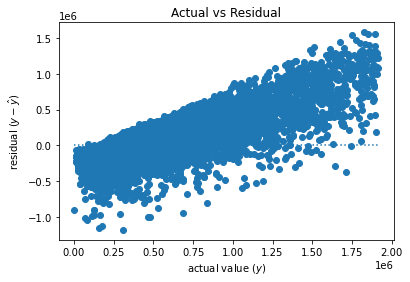

sse    1247712101615396.000
ess     710364006711556.250
tss    1958076108326954.250
mse         78511962095.104
rmse             280199.861
r^2                   0.363
dtype: float64

In [30]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled[['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet']], y_train.taxvaluedollarcnt)

# predict train
y_train['yhat_lm'] = lm.predict(X_train_scaled[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet']])

# compute residuals
y_train['residual'] = y_train['yhat_lm'] - y_train['taxvaluedollarcnt']
y_train['baseline_residual'] = y_train['yhat_baseline'] - y_train['taxvaluedollarcnt']

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.taxvaluedollarcnt, y_train.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on in-sample data
evaluate.regression_errors(y_train.taxvaluedollarcnt, y_train.yhat_lm)

### Lasso Lars Model

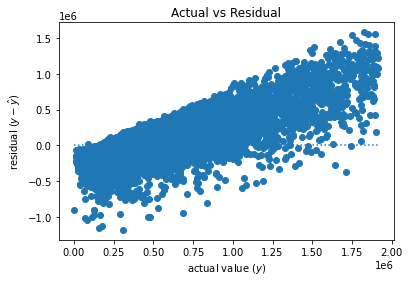

sse    1247713628265665.000
ess     709151757833752.500
tss    1958076108326954.250
mse         78512058159.179
rmse             280200.032
r^2                   0.362
dtype: float64

In [31]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet']], y_train.taxvaluedollarcnt)

# predict train
y_train['yhat_lars'] = lars.predict(X_train_scaled[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet']])

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.taxvaluedollarcnt, y_train.yhat_lars)

#Retrieve evaluation metrics for Lasso + Lars Model on in-sample data
evaluate.regression_errors(y_train.taxvaluedollarcnt, y_train.yhat_lars)

### TweedieRegressor (GLM) Model

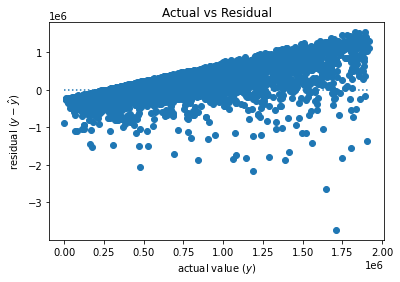

sse    1358005493931720.000
ess     819690721197125.625
tss    1958076108326954.250
mse         85452145351.858
rmse             292321.989
r^2                   0.419
dtype: float64

In [32]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet']], y_train.taxvaluedollarcnt)

# predict train
y_train['yhat_glm'] = glm.predict(X_train_scaled[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet']])

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.taxvaluedollarcnt, y_train.yhat_glm)

#How does the GLM model perform on in-sample data?
evaluate.regression_errors(y_train.taxvaluedollarcnt, y_train.yhat_glm)

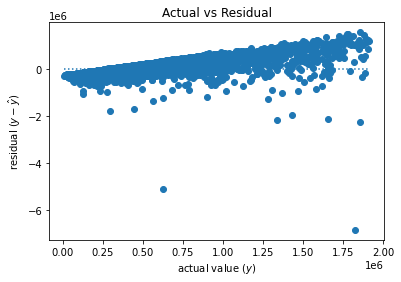

sse    635706409208569.625
ess    428911876361417.562
tss    827209173121576.750
mse        93321551557.336
rmse            305485.763
r^2                  0.519
dtype: float64

In [33]:
#How does the GLM model perform on out of sample data?

# predict validate
y_validate['yhat_glm'] = glm.predict(X_validate_scaled[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet']])

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_validate.taxvaluedollarcnt, y_validate.yhat_glm)

#Evaluation metrics report
evaluate.regression_errors(y_validate.taxvaluedollarcnt, y_validate.yhat_glm)

> **Takeaways:**<br>
    - I am saying that the TweedieRegressor GLM model is the best performing model on both the Train and Validate Subsets with an r^2 of ~62% meaning that 62% of the variance in y can be explained by x. <br>
    - This GLM Model also has a RMSE of $310,975 which still outpreforms the baseline model.

### USE GLM MODEL TO PREDICT ON TEST

In [34]:
# predict validate
y_test['yhat_glm'] = glm.predict(X_test_scaled[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet']])

# compute residuals
y_test['residual'] = y_test['yhat_glm'] - y_test['taxvaluedollarcnt']
y_test['baseline_residual'] = y_test['yhat_baseline'] - y_test['taxvaluedollarcnt']

#How does the GLM model perform on out of sample data?
evaluate.regression_errors(y_test.taxvaluedollarcnt, y_test.yhat_glm)

sse    507908370658998.875
ess    322583273977390.625
tss    696465908357941.500
mse        89483504344.432
rmse            299137.935
r^2                  0.463
dtype: float64

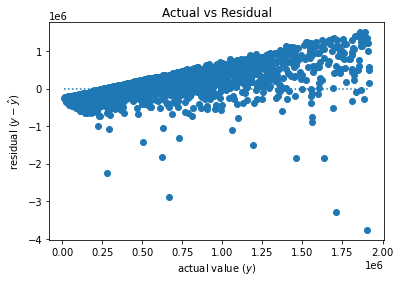

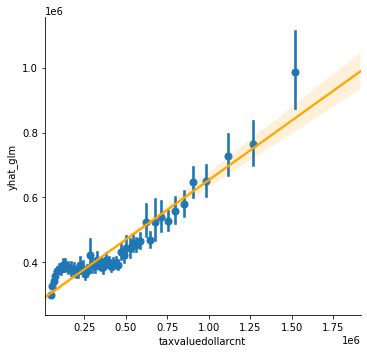

In [35]:
#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_test.taxvaluedollarcnt, y_test.yhat_glm)
sns.lmplot(x = 'taxvaluedollarcnt', y = 'yhat_glm', data = y_test,x_bins=50, fit_reg=True, line_kws={"color":"orange"})


> **Takeaways:**<br>
    - The GLM model performs better than the baseline model on the out-of-sample test dataframe with a r^2 of ~42% <br><br>
    - I will proceed with this model until a better model comes along or new data informs that this model should be rejected.